## Aram Data and Analysis

In [4]:
# imports
from league_data import *
from league_functions import *
from league_constants import *
import cassiopeia as cass
import plotly.express as px
import seaborn as sns

#### TODO
-convert to pandas(fetch and append and storing too)
<br> -finish fuctions
<br> -new function ideas
<br> -filtering base on x

#### Load Data

In [5]:
data = load_fetch_data(robb)
df = convert_df(data)

DATA LOADED 2981
Getting Match History
Total Games: 3010
NEW Games: 29
Getting Game Data
DATA ADDED 29 



In [6]:
champs = pd.Series(cass.get_champions(region="NA"))
champs.index = champs.apply(lambda x: x.name)
champs = champs.apply(lambda x: x.tags[0])

adc = set(champs[champs.apply(lambda x: "Marksman" in x)].index)
assassin = set(champs[champs.apply(lambda x: "Assassin" in x)].index)
fighter = set(champs[champs.apply(lambda x: "Fighter" in x)].index)
support = set(champs[champs.apply(lambda x: "Support" in x)].index)
tank = set(champs[champs.apply(lambda x: "Tank" in x)].index)
mage = set(champs[champs.apply(lambda x: "Mage" in x)].index)

#### Clean data

In [7]:
df.duration = df.duration.astype('timedelta64[s]')
df.patch = pd.to_numeric(df.patch.apply(lambda x: x.name))
df["side"] = df.where(df.side == 1).red.fillna(df.where(df.side == 0).blue)
df["teammates"] = df.side.apply(lambda x: {i.name.lower() for i in x})
df["teamcomp"] = df.side.apply(lambda x: {i.champ for i in x})
df["win"] = df.summoner.apply(lambda x: x.stats.win)

df.head(1)

,duration,season,patch,id,blue,red,summoner,side,teammates,teamcomp,win
0,1144.0,Season.season_9,11.12,3940477938,"[(Perfect Null, Viego), (huehuehhue, Sion), (y...","[(Dirty Doughnut, Annie), (Sháme, Sylas), (Get...",summoner_spell_d: Mark\nsummoner_spell_f: Flas...,"[(Dirty Doughnut, Annie), (Sháme, Sylas), (Get...","{dirty doughnut, sháme, hotg, get in the bag ,...","{Annie, Jhin, Garen, Senna, Sylas}",True


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3010 entries, 0 to 3009
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   duration   3010 non-null   float64
 1   season     3010 non-null   object 
 2   patch      3010 non-null   float64
 3   id         3010 non-null   int64  
 4   blue       3010 non-null   object 
 5   red        3010 non-null   object 
 6   summoner   3010 non-null   object 
 7   side       3010 non-null   object 
 8   teammates  3010 non-null   object 
 9   teamcomp   3010 non-null   object 
 10  win        3010 non-null   bool   
dtypes: bool(1), float64(2), int64(1), object(7)
memory usage: 238.2+ KB


#### Filter

In [9]:
df = df[df.patch.apply(round) == 11]
len(df)

807

In [10]:
solo = df[df.teammates.apply(lambda x: len(x & friends) == 0)]
premade = df[df.teammates.apply(lambda x: len(x & friends) != 0)]

In [11]:
wr(df)

Win     51.5%
Loss    48.5%
Name: win, dtype: object

In [12]:
wr(solo)

Win     51.4%
Loss    48.6%
Name: win, dtype: object

In [13]:
wr(premade)

Win     56.5%
Loss    43.5%
Name: win, dtype: object

In [14]:
wl = pd.DataFrame()

wl["wins"] = df[df.win == True].summoner.apply(lambda x: x.champion).value_counts()
wl["losses"] = df[df.win == False].summoner.apply(lambda x: x.champion).value_counts()
wl["losses"].fillna(value=0, inplace=True)
wl["total"] = wl.losses + wl.wins
wl["wr"] = round(wl.wins / wl.total, 2) * 100

wl[wl.total > 3].sort_values(by=["wr", "total"], ascending=False)

,wins,losses,total,wr
Thresh,13,2.0,15.0,87.0
Nasus,5,1.0,6.0,83.0
Darius,8,2.0,10.0,80.0
Galio,4,1.0,5.0,80.0
Cassiopeia,7,2.0,9.0,78.0
...,...,...,...,...
Taric,1,3.0,4.0,25.0
Lee Sin,3,10.0,13.0,23.0
Senna,2,8.0,10.0,20.0
Sylas,1,4.0,5.0,20.0


In [15]:
adc_games = df[df.teamcomp.apply(lambda x: len(x & adc) != 0)]
no_adc_games = df[df.teamcomp.apply(lambda x: len(x & adc) == 0)]

In [16]:
print(len(adc_games))
wr(adc_games)

651


Win     54.4%
Loss    45.6%
Name: win, dtype: object

In [17]:
print(len(no_adc_games))
wr(no_adc_games)

156


Win     39.7%
Loss    60.3%
Name: win, dtype: object

<AxesSubplot:xlabel='duration', ylabel='Count'>

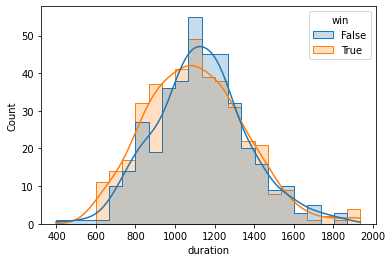

In [18]:
sns.histplot(df[["duration","win"]], x="duration", hue="win", element="step",kde=True)


#### Win Time distribution

In [19]:
df[df.win == True].duration.describe().drop("count").apply(lambda x: str(int(x // 60))+"m "+str(int(x%60))+"s")

mean    18m 26s
std       4m 9s
min      10m 4s
25%     15m 23s
50%     18m 16s
75%      21m 6s
max     32m 18s
Name: duration, dtype: object

#### Loss Time distribution

In [20]:
df[df.win == False].duration.describe().drop("count").apply(lambda x: str(int(x // 60))+"m "+str(int(x%60))+"s")

mean    18m 50s
std      3m 53s
min      6m 38s
25%     16m 30s
50%     18m 41s
75%      21m 9s
max     30m 51s
Name: duration, dtype: object

In [21]:
from collections import Counter

Counter(df.teammates.apply(list).sum()).most_common()[:50]

[('dirty doughnut', 807),
 ('evian ice', 385),
 ('phill or pheed', 104),
 ('milo dinosaur', 85),
 ('big benis boy', 69),
 ('mizero1', 59),
 ('diehardorgohome', 23),
 ('rdinho9', 20),
 ('dodge down', 14),
 ('amenadiel', 13),
 ('a0garen0a', 10),
 ('grace', 8),
 ('amedrash', 6),
 ('derroz', 5),
 ('yze', 5),
 ('brightest flame4', 5),
 ('angela 77', 5),
 ('cloudlightfellow', 4),
 ('father relax', 4),
 ('the ibaggins', 4),
 ('vitaminalpha', 4),
 ('top8 always', 4),
 ('rockingbanana', 4),
 ('quiexent', 4),
 ('lychguard', 4),
 ('annïe', 3),
 ('isogay', 3),
 ('tilltheday', 3),
 ('closetochuck', 3),
 ('jakedaddydad', 3),
 ('uwuwuwuwwuwuwuw', 3),
 ('johnlegends1000', 3),
 ('mafewma', 3),
 ('sem3nspreader', 3),
 ('gotta let me fly', 3),
 ('clifer', 3),
 ('omar zi savage', 3),
 ('trashaim', 3),
 ('alphazhu', 3),
 ('c bal', 3),
 ('hide above bush1', 3),
 ('fruittartare', 3),
 ('viideojames', 3),
 ('cheez wolf', 3),
 ('zoomer darius', 3),
 ('kurokos penguin', 3),
 ('toneenot', 3),
 ('douchepouche', 3

In [22]:
wr(df[df.teamcomp.apply(lambda x: "Yasuo" in  x)])

Win     56.8%
Loss    43.2%
Name: win, dtype: object

In [23]:
# win_rate(data)
# champ_winrate(data)
# champ_kda(robb, Aram_Data)
# kda(Aram_Data)
# kp(Aram_Data)
# common_teammates(Aram_Data)
# multikills(Aram_Data)
# items(Aram_Data)
adc_winrate(data)
# time_played(Aram_Data)
# win_rate_with(thomas, Aram_Data)
# time_distribution(robb, data)


# a  = dill.load(open("Aram_Data_New.pickle", "rb"))
# print(a[0].summoner.stats.first_inhibitor_kill)

With adc winrate: 54.68%
No adc winrate: 51.9%

